In [ ]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Download NVIDIA historical data from 2014 to 2024

In [ ]:
# Methods
def download_historical_data(start_date, end_date, stock='NVDA'):
  df = yf.download(stock, start=start_date, end=end_date)
  return df

def describe_df(df, df_name):
  print('\ndescribe_df() :: {} - Shape: {}'.format(df_name, df.shape))
  print('describe_df() :: {} - Columns: {}'.format(df_name, df.columns))


start_date = '2014-01-01'
end_date = '2024-03-31'
stock = 'NVDA'
historical_data_df = download_historical_data(start_date=start_date,
                                              end_date=end_date,
                                              stock=stock)

# describe
describe_df(historical_data_df, 'historical_data_df')

[*********************100%%**********************]  1 of 1 completed


describe_df() :: historical_data_df - Shape: (2577, 6)
describe_df() :: historical_data_df - Columns: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [ ]:
# Data
historical_data_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,3.9800,3.995,3.9300,3.9650,3.740547,26009200
2014-01-03,3.9725,3.980,3.9050,3.9175,3.695736,25933200
2014-01-06,3.9575,4.000,3.9200,3.9700,3.745265,40949200
2014-01-07,4.0100,4.050,3.9825,4.0350,3.806585,33328800
2014-01-08,4.0500,4.110,4.0350,4.0900,3.858471,30819200


## Visualizing NVIDIA Close from 2014 to 2024

* NVIDIA rose due to Bitcoin Mining initially
* 2018 - NVIDIA Crashed due to BTC Crash
* 2020 - NVIDIA Rose due to pandemic (Gaming, Research etc)
* 2022 - NVIDIA slowed due to Inflation, War (Russia - Ukraine)
* 2023 - NVIDIA shot up due Open AI advancement


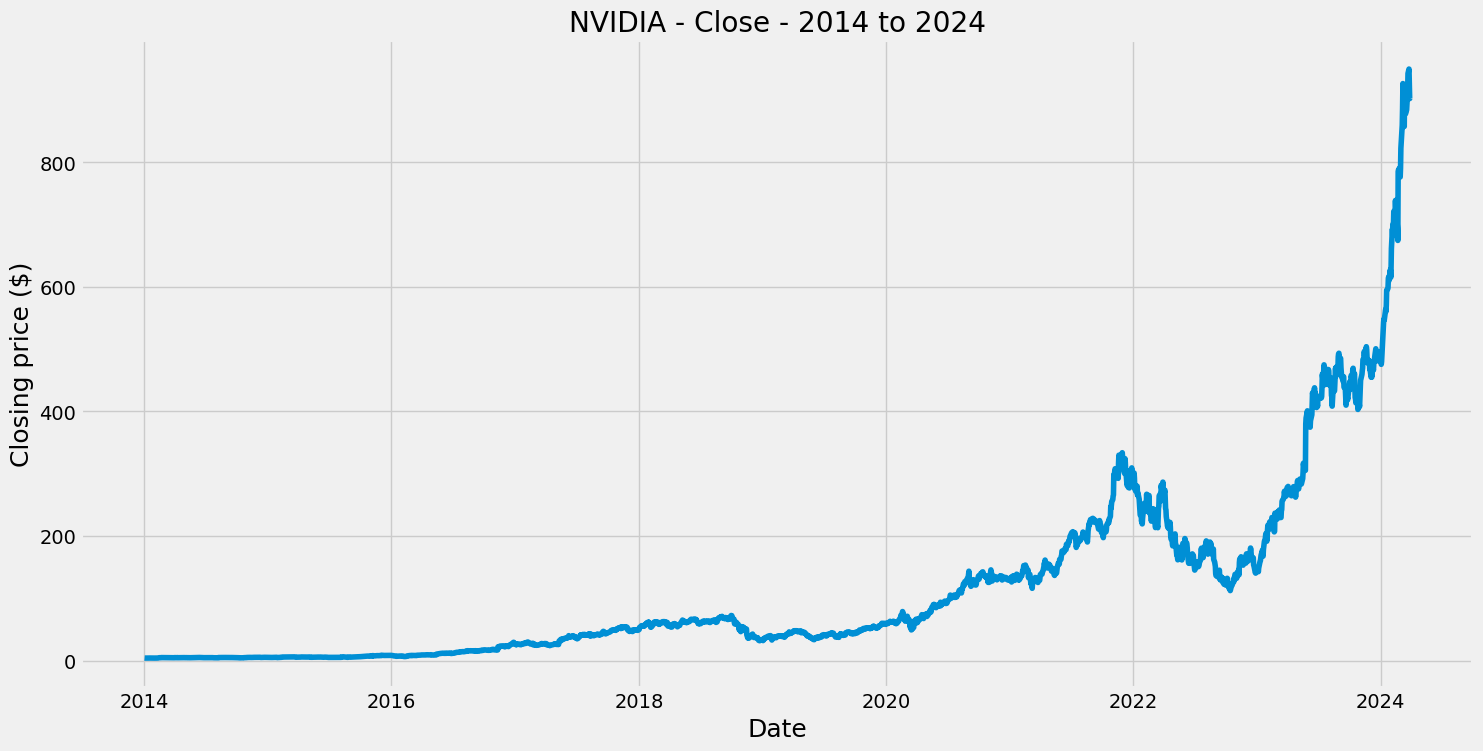

In [ ]:
# Plot closing price
def plot_attribute(df, column_name):
  # plt.style.use('fivethirtyeight')
  plt.figure(figsize=(16, 8))
  plt.title('NVIDIA - {} - 2014 to 2024'.format(column_name))
  plt.plot(df[column_name])
  plt.xlabel('Date',fontsize=18)
  plt.ylabel('Closing price ($)',fontsize=18)
  plt.show()

plot_attribute(historical_data_df, 'Close')

## Visualizing - Rolling Mean 100 and 200 days

Text(0.5, 1.0, 'Close Vs 100 days Vs 200 days - Moving Averages')

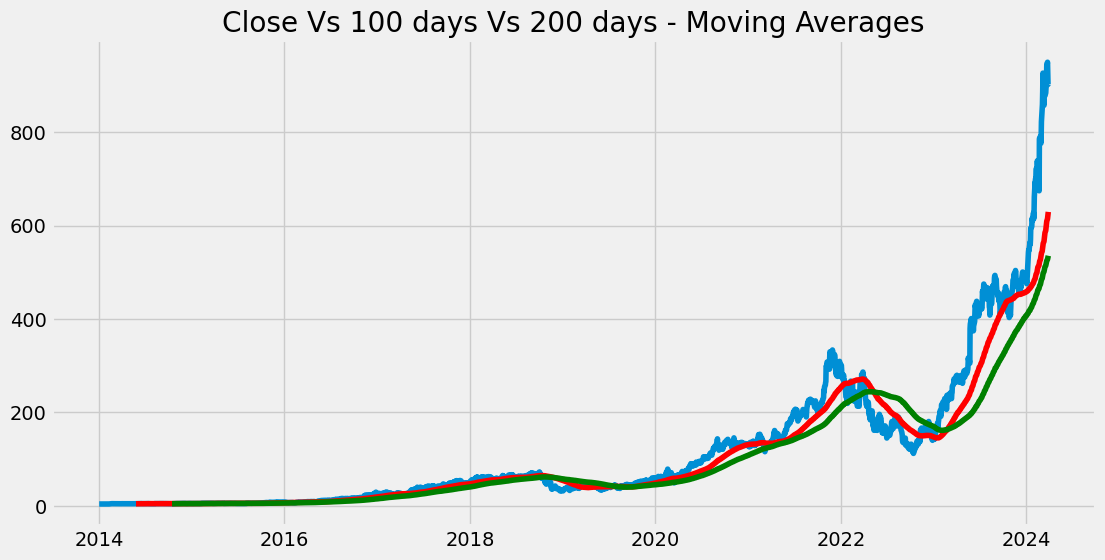

In [ ]:
df = historical_data_df.copy()
# df = df.filter(['Close'])
moving_average_100_days = df.Close.rolling(100).mean()
moving_average_200_days = df.Close.rolling(200).mean()

plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(moving_average_100_days, 'r')
plt.plot(moving_average_200_days, 'g')
plt.title('Close Vs 100 days Vs 200 days - Moving Averages')

In [ ]:
# Train & Test (70-30)
def split_train_test_data(df, training_data_length):
  train_df = pd.DataFrame(df[0 : training_data_length])
  test_df = pd.DataFrame(df[training_data_length : int(len(df))])
  describe_df(train_df, 'train_df')
  describe_df(test_df, 'test_df')
  return train_df, test_df

train_data_percentage = 0.70
training_data_length = math.ceil(len(df) * train_data_percentage)
train_df, test_df = split_train_test_data(df, training_data_length)


describe_df() :: train_df - Shape: (1804, 6)
describe_df() :: train_df - Columns: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

describe_df() :: test_df - Shape: (773, 6)
describe_df() :: test_df - Columns: Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


## Data Preprocessing

In [ ]:
# MinMax Scaler - Dataset Normalization
def scale_data(scaled_data, training_data_length, batch_size):

  train_data = scaled_data[0:training_data_length, :]

  x_train=[]
  y_train=[]
  for i in range(batch_size, len(train_data)):
    x_train.append(train_data[i - batch_size : i, 0])
    y_train.append(train_data[i, 0])

  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  print('scale_data() Shape: x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

  return x_train, y_train

batch_size = 60

data = df.filter(['Close'])
dataset = data.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
x_train, y_train = scale_data(scaled_data, training_data_length, batch_size)

scale_data() Shape: x_train: (1744, 60, 1), y_train: (1744,)


## Model Creation, Fitting

In [ ]:
def get_model(optimizer, loss, metrics, x_train, y_train, epochs, batch_size=60):
  model = Sequential()

  # model.add(LSTM(units = 50,
  #                activation = 'relu',
  #                return_sequences=True,
  #                input_shape = (x_train.shape[1], 1)))
  # model.add(Dropout(0.2))
  # model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
  # model.add(Dropout(0.3))
  # model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
  # model.add(Dropout(0.4))
  # model.add(LSTM(units = 120, activation = 'relu'))
  # model.add(Dropout(0.5))
  # model.add(Dense(units = 1))

  # model = Sequential()
  # model.add(LSTM(units=100, return_sequences=True, input_shape=(x_train.shape[1],1)))
  # model.add(Dropout(0.3))
  # model.add(LSTM(units=80, return_sequences=True))
  # model.add(Dropout(0.1))
  # model.add(LSTM(units=50, return_sequences=True))
  # model.add(Dropout(0.2))
  # model.add(LSTM(units=30))
  # model.add(Dropout(0.3))
  # model.add(Dense(units=1))

  model=Sequential()
  model.add(LSTM(50,return_sequences=True, input_shape= (x_train.shape[1],1)))
  model.add(LSTM(50,return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  model.summary()
  model.compile(optimizer=optimizer, loss=loss)
  # history = model.fit(x_train, y_train, epochs=50, batch_size=60)
  history = model.fit(x_train, y_train, epochs=1, batch_size=2)

  return model, history

optimizer = 'adam'
loss = 'mean_squared_error'
metrics = ['MAE', 'accuracy']
epochs = 50
model, history = get_model(optimizer=optimizer,
                           loss=loss,
                           metrics=metrics,
                           x_train=x_train,
                           y_train=y_train,
                           epochs=epochs,
                           batch_size=batch_size)

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 60, 50)            10400     
                                                                 
 lstm_61 (LSTM)              (None, 50)                20200     
                                                                 
 dense_19 (Dense)            (None, 25)                1275      
                                                                 
 dense_20 (Dense)            (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
872/872 [==============================] - 31s 31ms/step - loss: 6.5888e-05


## Save Model

In [ ]:
best_model = 'lstm_best.keras'
model_50_60 = 'model_50_60'

# model.save(best_model)
# print('Model: {}'.format(best_model))

def save_model(model, model_name):
  model.save(model_name)
  print('Model: {} saved!'.format(model_name))

save_model(model, model_50_60)
save_model(model, best_model)

Model: model_50_60 saved!
Model: lstm_best.keras saved!


## Prepare test data

In [ ]:
def get_test_data(scaled_data, batch_size, training_data_length):
  test_data = scaled_data[training_data_length - batch_size:, :]
  x_test=[]
  y_test = dataset[training_data_length:, :]
  for i in range (batch_size, len(test_data)):
    x_test.append(test_data[i-batch_size:i, 0])
  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  print('get_test_data() Shape: x_test: {}, y_test: {}'.format(x_test.shape, y_test.shape))
  return x_test, y_test

x_test, y_test = get_test_data(scaled_data, batch_size, training_data_length)

get_test_data() Shape: x_test: (773, 60, 1), y_test: (773, 1)


## Make Predictions

In [ ]:
y_predictions = model.predict(x_test)
predictions = scaler.inverse_transform(y_predictions)
# y_predictions

25/25 [==============================] - 2s 27ms/step


## Error Calculation

In [ ]:
def calculate_errors(y_test, y_predictions):
  mae = mean_absolute_error(y_test, y_predictions)
  mse = mean_squared_error(y_test, y_predictions)
  rmse = np.sqrt( np.mean( y_predictions - y_test ) ** 2 )
  print("calculate_errors() :: mean_absolute_error on test set: {}".format(mae))
  print("calculate_errors() :: mean_squared_error on test set: {}".format(mse))
  print("calculate_errors() :: rmse on test set: {}".format(rmse))

calculate_errors(y_test, predictions)

calculate_errors() :: mean_absolute_error on test set: 27.37533242643882
calculate_errors() :: mean_squared_error on test set: 1970.9529954981213
calculate_errors() :: rmse on test set: 23.379548668707173


## Visualizing -  Original Vs Predicitions data

<ipython-input-195-245d23ffef5e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = y_predictions


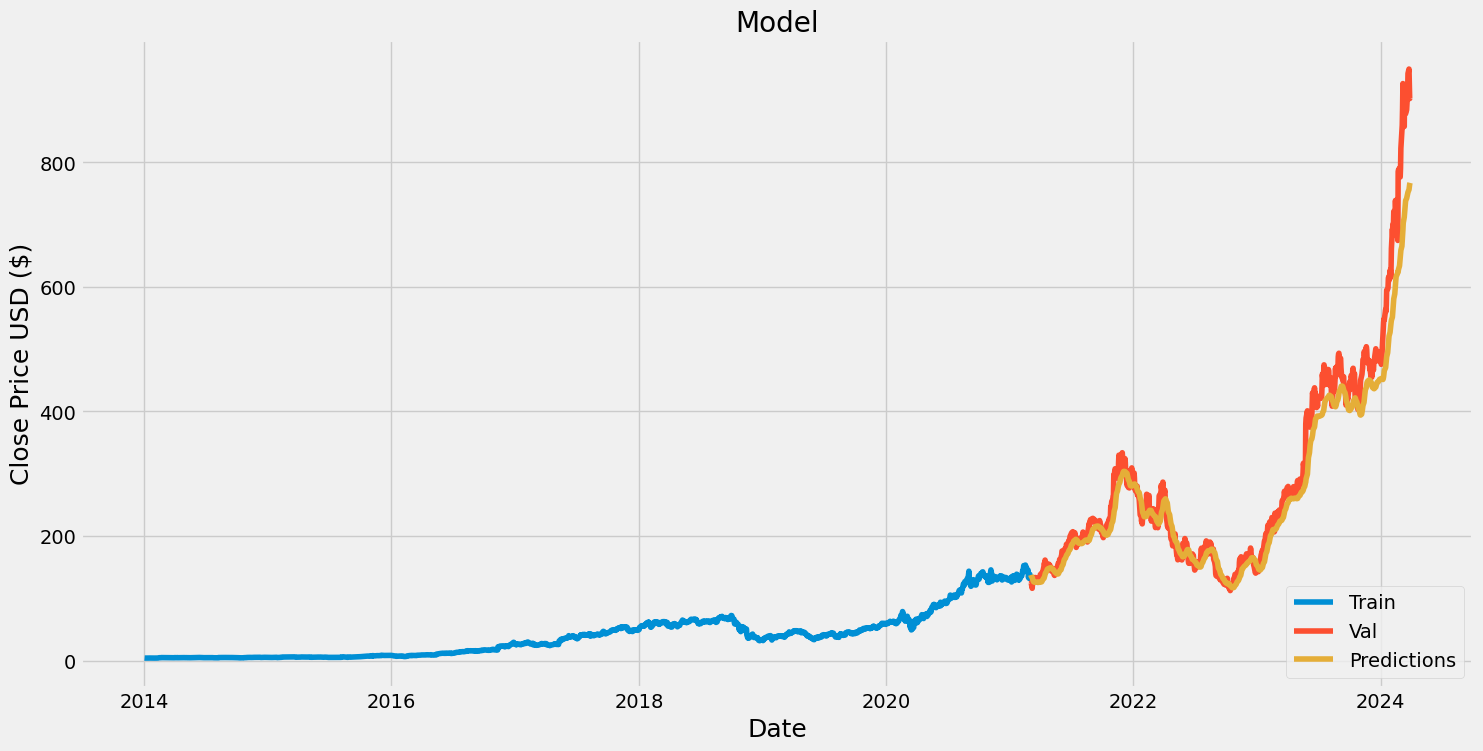

In [ ]:
#Plot the data
def plot_original_vs_predictions(df, y_predictions, training_data_length):
  train = df[:training_data_length]
  valid = df[training_data_length:]
  valid['Predictions'] = y_predictions
  #visualize the data
  plt.figure(figsize=(16,8))
  plt.title('Model')
  plt.xlabel('Date',fontsize=18)
  plt.ylabel('Close Price USD ($)',fontsize=18)
  plt.plot(train['Close'])
  plt.plot(valid[['Close', 'Predictions']])
  plt.legend(['Train','Val','Predictions'], loc='lower right')
  plt.show()

plot_original_vs_predictions(df, predictions, training_data_length)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data Preparation
data = historical_data_df.filter(['Close'])
dataset = data.values

# Scale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)

# Generate features and labels
time_step =60
def create_dataset(dataset, time_step=1):
    X, Y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        Y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(Y)

# time_step = 60
X, y = create_dataset(scaled_data, time_step)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Random Forest Model
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=0)
random_forest_model.fit(X_train, y_train)

# Predictions
y_pred_rf = random_forest_model.predict(X_test)
y_pred_rf = scaler.inverse_transform(y_pred_rf.reshape(-1, 1))  # Rescaling to original scale

# Calculate MAE and MSE for Random Forest
mae_rf = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_rf)
mse_rf = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_rf)
print(f"Random Forest MAE: {mae_rf}, MSE: {mse_rf}")

Random Forest MAE: 3.1100200893389403, MSE: 37.96971679552595


## SVM

In [ ]:
from sklearn.svm import SVR

# Support Vector Machine Model
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test)
y_pred_svm = scaler.inverse_transform(y_pred_svm.reshape(-1, 1))  # Rescaling to original scale

# Calculate MAE and MSE for SVM
mae_svm = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_svm)
mse_svm = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), y_pred_svm)
print(f"SVM MAE: {mae_svm}, MSE: {mse_svm}")


SVM MAE: 8.623420659833535, MSE: 112.73611180731466


## Visualizing - Random Forest, SVM Predictions and Original Values

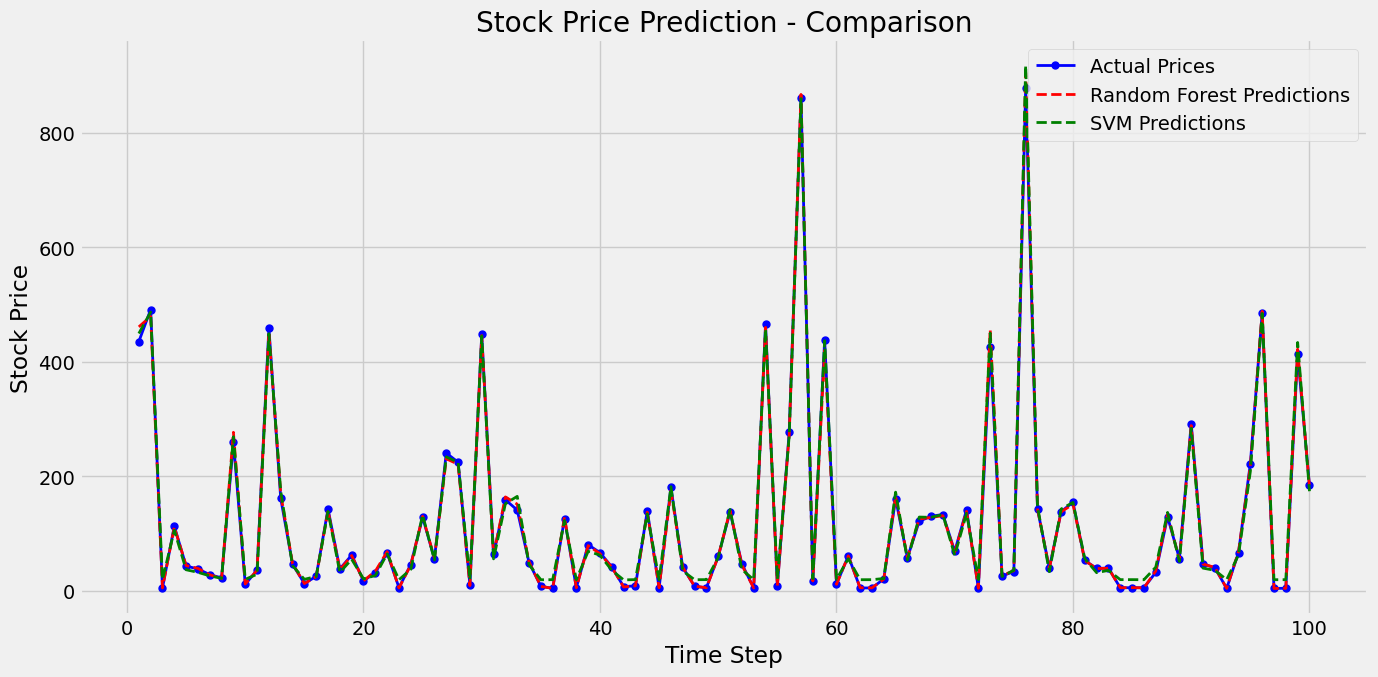

In [ ]:
# Plot improvements for clarity
plt.figure(figsize=(14, 7))

# Select a subset of the test data to plot for clearer visualization
plot_data_length = 100  # Adjust based on your preference for plot clarity
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))[-plot_data_length:]
rf_predictions = y_pred_rf[-plot_data_length:]
svm_predictions = y_pred_svm[-plot_data_length:]
time_steps = list(range(1, plot_data_length + 1))

# Actual Prices
plt.plot(time_steps, actual_prices, marker='o', linestyle='-', color='blue', label='Actual Prices', linewidth=2, markersize=5)

# Random Forest Predictions
plt.plot(time_steps, rf_predictions, marker='', linestyle='--', color='red', label='Random Forest Predictions', linewidth=2)

# SVM Predictions
plt.plot(time_steps, svm_predictions, marker='', linestyle='--', color='green', label='SVM Predictions', linewidth=2)

plt.title('Stock Price Prediction - Comparison')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.tight_layout()
plt.show()
